In [3]:
class Node:
    def __init__(self,id, minCharAscii = ord('$'), maxCharAscii= ord('~')) -> None:
        self.start =None
        self.end = None
        self.children = (maxCharAscii+1- minCharAscii) * [None]
        self.minCharAscii = minCharAscii
        self.maxCharAscii = maxCharAscii
        self.suffixLink = None
        self.id =id 
    @property
    def end_value(self):
        return self.end[0] if self.end is not None else None
    def __getCharIndex(self, char):
        return ord(char)-self.minCharAscii
    
    def __setitem__(self, key:str, value):
        key = self.__getCharIndex(key)
        self.children[key] = value
    def __getitem__(self, key:str):
        key = self.__getCharIndex(key)
        return self.children[key]
    def getCopy(self):
        newNode = Node(self.id)
        newNode.start = self.start
        newNode.end = self.end
        newNode.children = self.children
        newNode.suffixLink = self.suffixLink
        newNode.minCharAscii = self.minCharAscii
        newNode.maxCharAscii = self.maxCharAscii
        
        return newNode

        
        return 
    def __str__(self) -> str:
        return f"start: {self.start}, end: {self.end}, children: {[child.start  for child in self.children if child!=None]}, suffixLink: {self.suffixLink}"

In [ ]:
a = [1]
b = a
a[0] = 2
b[0]

In [ ]:
val = [3]
a = Node(0,val)

print(a.end_value)

val[0] =5
print(a.end_value)


In [4]:
import graphviz

In [5]:
class SuffixTree:
    def __init__(self, minChar = '$', maxChar = '~') -> None:
        self.extension =0
        self.counter =0
        self.maxChar = maxChar
        self.minChar = minChar
        self.root = self.add(0, isRoot=True)
        self.activeNode = self.root
        self.end = [-1]
        self.activeEdge = -1
        self.activeLength = 0  
        self.lastJ= 0
        self.prevActive =None
        self.watch = None
        
    def add(self, s, isRoot= False)->Node:
        newNode = Node(self.counter, minCharAscii=ord(self.minChar), maxCharAscii=ord(self.maxChar))
        self.counter+=1
        newNode.start = s # start index of the suffix
        if isRoot:
            newNode.end = [-1]
            newNode.suffixLink = newNode
        else:
            newNode.end = self.end # global end
            newNode.suffixLink = self.root #set suffix link to root for now
        return newNode
    def __getCharIndex(self, char):
        return ord(char)-ord(self.minChar)

    
    def __insert(self,text, p, verbose=False):
        startChar = text[self.activeEdge]
        n = self.activeNode[startChar]
        
        newNode =None
        #need to fix 
        #check if its leaf node
        #need to check if active length =0
        if self.activeLength ==0:
            self.add(p)
            newNode = self.add(p)
            lastChar = text[p]
            self.activeNode[lastChar] = newNode
            if verbose: print(f'rule 2b branching {self.__printSubString(text, n)}, new {self.__printSubString(text, newNode)}')
        elif n.end_value- n.start +1 != self.activeLength:
            

            newRemNode = n.getCopy()
            newRemNode.start = n.start+self.activeLength
            newStartNode = self.add(n.start)
            newStartNode.end = [n.start + self.activeLength-1]
            n = newStartNode
            self.activeNode[startChar] = n
            newNode = self.add(p)
            
            activeNodeStartChar = text[newNode.start]
            remNodeStartChar = text[newRemNode.start]
            n[activeNodeStartChar] = newNode
            n[remNodeStartChar] = newRemNode
            if verbose: print(f'rule 2a branching {self.__printSubString(text, n)}, rem {self.__printSubString(text, newRemNode)} {newRemNode.start, newRemNode.end}, new {self.__printSubString(text, newNode)}')
            
        # else:
        #     #case 2b 
        #     newNode = self.add(p)
        #     lastChar = text[p]
        #     n[lastChar] = newNode
        #     if verbose: print(f'rule 2b branching {self.__printSubString(text, n)}, new {self.__printSubString(text, newNode)}')
        #if active node is root
        if self.activeNode == self.root:
            self.activeEdge = self.activeEdge +1
            self.activeLength = self.activeLength -1
       
        self.lastJ+=1
        if self.prevActive is not None:
            self.prevActive.suffixLink = n
            if verbose: print(f'added suffix link from {self.prevActive.id} to {n.id}')
        self.prevActive = n

    
    def __contain(self, text,e, p, verbose= False):
        """
        e: start of substring from rule 3
        p: current phase- end of substring need to check if p contain
        """
        activeEdgeChar = text[self.activeEdge]
        # if self.activeLength ==0:
        #     nextChar = text[p]
        #     return self.activeNode[nextChar] is not None
        n:Node = self.activeNode[activeEdgeChar]
        nodeLength = n.end_value - n.start
        valueCheck = n.start 
        

        if nodeLength < p-e:
            #need to switch active node
            # nextCharIndex = n.end_value+ (p-e - nodeLength)
            nextCharIndex = e+nodeLength+1
            nextChar= text[nextCharIndex]
            if n[nextChar] is None:
                return False
            self.activeNode = n
            self.activeEdge = n[nextChar].start
            if verbose: print(f'change active node, active edge {text[self.activeEdge]} ({self.activeEdge}) active length before {self.activeLength}, active length new {self.activeLength -1- (nodeLength )} active edge{self.activeEdge} node length{nodeLength} ')

            self.activeLength = self.activeLength -1 - nodeLength 
            #need to fix suffix length
            # self.activeLength = 1
            return self.__contain(text, e+nodeLength,p)
            
        else:
            #check if it matches
            #maybe should chekc
            if text[valueCheck + self.activeLength] == text[p]:

                #rule 3 
                self.activeLength = self.activeLength +1
                if verbose: print(f'rule 3 {text[e:p+1]} in {self.__printSubString(text, n)}')
                return True
                
            return False
            
    
    def insertAll(self, text:str, verbose=False):
        self.lastJ =0
        #phase
        for p in range(len(text)):
            #rule 1
            self.end[0]= self.end[0]+1
            #extension
            self.prevActive = None
            for e in range(self.lastJ, p+1):

                if verbose: print(f'phase:{p}, extn:{e} inserting {text[e:p+1]}, active length {self.activeLength} active edge {self.activeEdge} ')
                if self.activeLength ==0 and self.activeNode == self.root:
                    #check root
                    if self.activeNode.children[self.__getCharIndex(text[e])] is None:
                        self.activeNode.children[self.__getCharIndex(text[e])] = self.add(e)
                        self.lastJ +=1
                        self.activeEdge =-1
                        self.activeLength = 0
                        if verbose: print(f'rule 2 from root')
                    else:
                        self.activeLength = self.activeLength +1
                        self.activeEdge = self.activeNode.children[self.__getCharIndex(text[e])].start
                    
                        if verbose: print(f'rule 3, active edge = {text[e]} ')
                        break
                else:
                    if self.__contain(text,e, p, verbose):
                        break
                    else:
                        self.__insert(text, p, verbose)                        
                        if verbose: print(f'Current active node {self.activeNode.id}, jumping to suffix link {self.activeNode.suffixLink.id}')
                        
                        self.activeNode = self.activeNode.suffixLink
                        

                
                
    def __printSubString(self, text, node:Node):
        return text[node.start:node.end_value+1]
    def printTree(self, text:str):
        dot = graphviz.Digraph(comment='Suffix Tree')
    
        def printTreeAux(node):
            for child in node.children:
                if child:
                    label = text[child.start:child.end_value+1] + f'(id{child.id}: {child.start},{child.end_value})'
                    dot.node(str(child.id), label)
                    dot.edge(str(node.id), str(child.id))
                    if child.suffixLink!= self.root:
                        dot.edge(str(child.id), str(child.suffixLink.id), style='dashed')
                    printTreeAux(child)

        printTreeAux(self.root)  # Assuming `self.root` is the root of your tree
        return dot
        


phase:0, extn:0 inserting r, active length 0 active edge -1 
rule 2 from root
phase:1, extn:1 inserting a, active length 0 active edge -1 
rule 2 from root
phase:2, extn:2 inserting t, active length 0 active edge -1 
rule 2 from root
phase:3, extn:3 inserting t, active length 0 active edge -1 
rule 3, active edge = t 
phase:4, extn:3 inserting ta, active length 1 active edge 2 
rule 2a branching t, rem ta (3, [4]), new a
Current active node 0, jumping to suffix link 0
phase:4, extn:4 inserting a, active length 0 active edge 3 
rule 3, active edge = a 
phase:5, extn:4 inserting at, active length 1 active edge 1 
rule 3 at in attat
phase:6, extn:4 inserting ata, active length 2 active edge 1 
rule 2a branching at, rem tata (3, [6]), new a
Current active node 0, jumping to suffix link 0
phase:6, extn:5 inserting ta, active length 1 active edge 2 
change active node, active edge a (4) active length before 1, active length new 0 active edge4 node length0 
phase:7, extn:5 inserting tat, acti

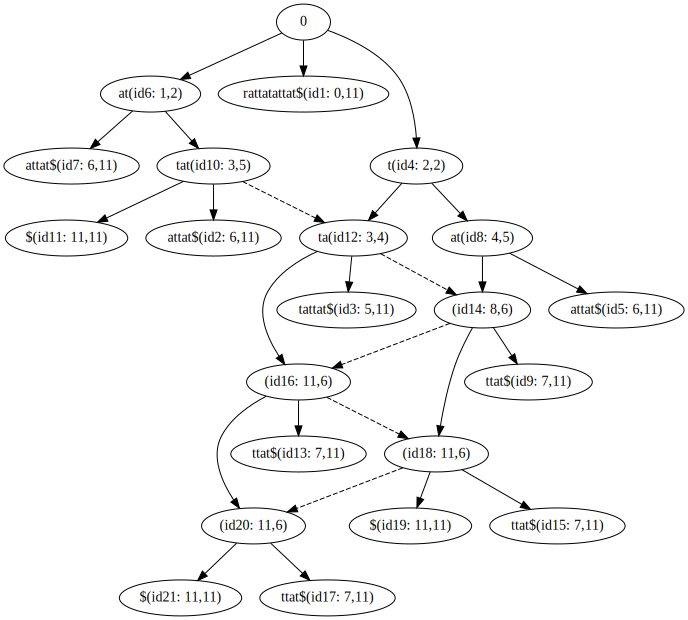

In [12]:
s = "xyzxyaxyz$"
s1 ="mississi$"
s2= "rattatattat$"
s3 = "AAAABAAAABAAC"
s4= "xxxyxx$"
s5="abaaba"
st = SuffixTree()
st.insertAll(s2, verbose=True)
st.printTree(s2)